In [1]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import numpy as np
import joblib
import sys
import imodelsx.process_results
from notebook_helper import calc_mean_std_across_curves
sys.path.append('../experiments/')
results_dir = '../results/'

r = imodelsx.process_results.get_results_df(results_dir)
experiment_filename = '../experiments/01_train_model.py'
r = imodelsx.process_results.fill_missing_args_with_default(r, experiment_filename)
# r.to_pickle('../results/agg.pkl')

100%|██████████| 3022/3022 [00:03<00:00, 775.10it/s] 


In [3]:
ravg = []
group_keys = [k for k in imodelsx.process_results.get_main_args_list(experiment_filename='01_train_model.py') if not k == 'seed']
rg = r.groupby(group_keys)
for group_key, group_idx in rg.groups.items():
    g = r.iloc[group_idx]
    numeric_keys = [k for k in list(g.select_dtypes("number")) if not k in group_keys]
    # numeric_keys = ['roc_auc_test', 'stability']
    row = g[numeric_keys].mean()
    for k in group_keys:
        row[k] = g[k].iloc[0]
    try:
        row['instability'] = calc_mean_std_across_curves(g['shape_function_vals_list'].values.tolist())
        ravg.append(row)
    except:
        pass

In [4]:
# df = pd.DataFrame(ravg)
# k = 'reg_param_marginal'
# for val in df[k].unique():
#     print(f'k={k}, val={val}')
#     df = pd.DataFrame(ravg)
#     df = df[~((df.n_boosting_rounds == 0) & (df.n_boosting_rounds_marginal == 0))]
#     df = df[df[k] == val]
#     print('ROC AUC:')
#     display(
#         df.pivot_table(
#             index="n_boosting_rounds",
#             columns="n_boosting_rounds_marginal",
#             values="roc_auc_test",
#             aggfunc="mean",
#         )
#         .style.format(precision=3)
#         .background_gradient(cmap="RdBu", axis=None)
#     )
#     print('Instability:')
#     display(
#         (df.pivot_table(
#             index="n_boosting_rounds",
#             columns="n_boosting_rounds_marginal",
#             values="instability",
#             aggfunc="mean",
#         ))
#         .style.format(precision=4)
#         .background_gradient(cmap="RdBu_r", axis=None)
#     )

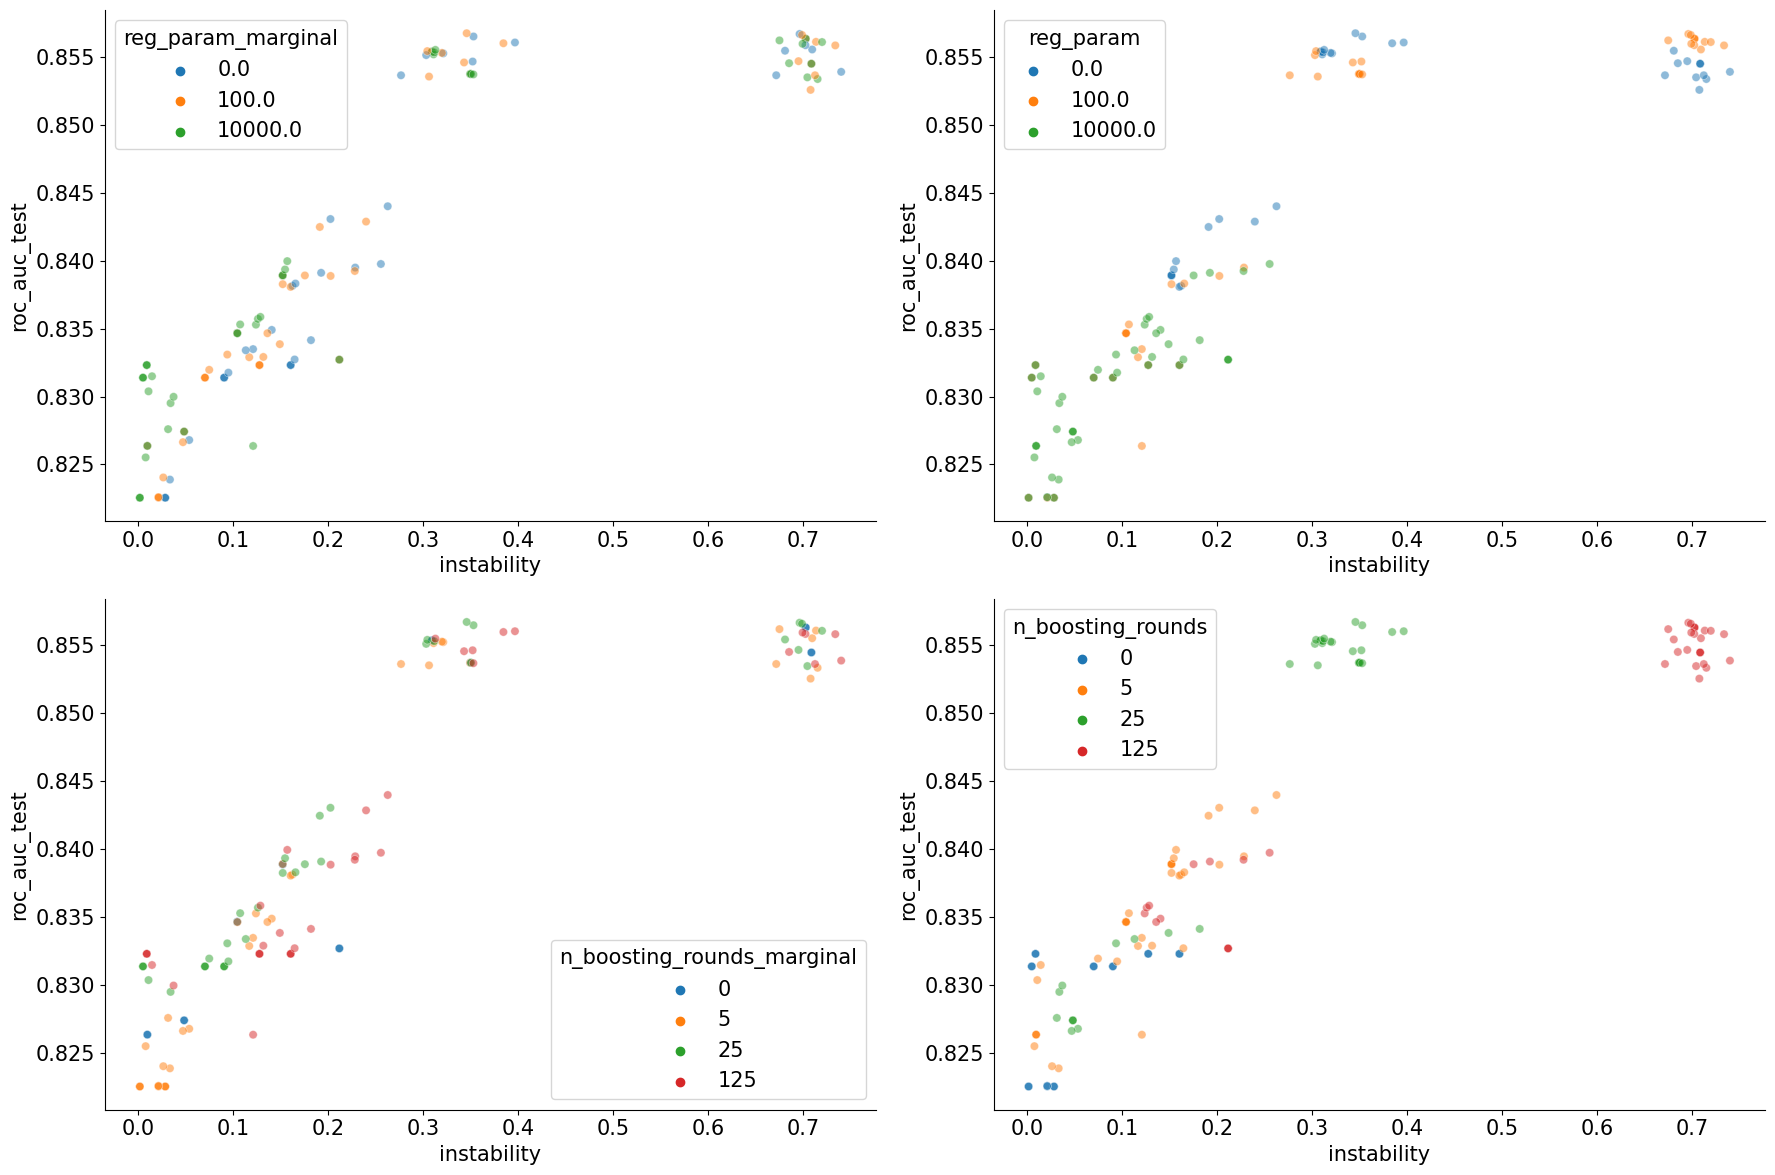

: 

In [5]:
df = pd.DataFrame(ravg)
df = (
    df.groupby([k for k in group_keys if not k == "dataset_name"])[
        ["roc_auc_test", "instability"]
    ]
    .mean()
    .reset_index()
)
df = df[~((df.n_boosting_rounds == 0) & (df.n_boosting_rounds_marginal == 0))]
# df = df[df.fit_linear_marginal == "None"]
# df = df[df.n_boosting_rounds == 0]
# df = df[df.n_boosting_rounds_marginal == 5]
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
kwargs = dict(
    data=df,
    x="instability",
    y="roc_auc_test",
    palette="tab10",
    alpha=0.5,
)
sns.scatterplot(
    **kwargs,
    hue="reg_param_marginal",
    ax=axes[0, 0],
)
sns.scatterplot(
    **kwargs,
    hue="reg_param",
    # hue="n_boosting_rounds_marginal",
    # hue="n_boosting_rounds",
    ax=axes[0, 1],
)
sns.scatterplot(
    **kwargs,
    hue="n_boosting_rounds_marginal",
    ax=axes[1, 0],
)
sns.scatterplot(
    **kwargs,
    hue="n_boosting_rounds",
    ax=axes[1, 1],
)
plt.show()